We adapt the [IceVision meets W&B](https://airctic.com/0.12.0/wandb_efficientdet/) tutorial to the Crowd AI Mapping Challenge dataset. 
The goal of this notebook is to train various state of the art models in object detection and log the various metadata, metrics, and model
in Weights and Bias.

Also see [this](https://wandb.ai/meghal/RoadSignDetection/reports/Choosing-the-right-model-for-object-detection--VmlldzoxNzA2NDA5) tutorial on
using wandb with IceVision.

This notebook assumes the scripts preprocess-annotations.py and cache-records.py were run.

Work in the project directory to avoid file not found errors.

In [2]:
%cd ..

## Install IceVision and IceData
If on Colab run the following cell, else check the [installation instructions](https://airctic.com/dev/install/)

Install from pypi...

In [ ]:
# Torch - Torchvision - IceVision - IceData - MMDetection - YOLOv5 - EfficientDet Installation
!wget https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh

# Choose your installation target: cuda11 or cuda10 or cpu
!bash icevision_install.sh cuda11

... or from icevision master

In [ ]:
# # Torch - Torchvision - IceVision - IceData - MMDetection - YOLOv5 - EfficientDet Installation
# !wget https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh

# # Choose your installation target: cuda11 or cuda10 or cpu
# !bash icevision_install.sh cuda11 master

In [ ]:
# Restart kernel after installation
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'restart': True, 'status': 'ok'}

## Imports

In [1]:
from icevision.all import *
from fastai.callback.wandb import *
from fastai.callback.tracker import SaveModelCallback

INFO     - Downloading default `.ttf` font file - SpaceGrotesk-Medium.ttf from https://raw.githubusercontent.com/airctic/storage/master/SpaceGrotesk-Medium.ttf to /root/.icevision/fonts/SpaceGrotesk-Medium.ttf | icevision.visualize.utils:get_default_font:67
INFO     - Downloading mmdet configs | icevision.models.mmdet.download_configs:download_mmdet_configs:31


0B [00:00, ?B/s]

## Load the Crowd AI Mapping Challenge Dataset

In [2]:
# Create the parser
parser = parsers.COCOBBoxParser(annotations_filepath= "data/train/annotation-small3.json", img_dir="data/train/images")

In [3]:
# Parse annotations to create records
train_records, valid_records = parser.parse(cache_filepath="data/train/cache-records3.p")
parser.class_map

INFO     - Loading cached records from data/train/cache-records3.p | icevision.parsers.parser:parse:113


<ClassMap: {'background': 0, 'building': 1}>

## Train and Validation Datasets

As a simple start, we'll resize the images from 300x300 to 384x384. This way we can train
several different models.

In [4]:
# Transforms
image_size = 384

train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=image_size, presize=512), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])

In [5]:
# Datasets
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

## Create the model
We'll try a variety of different models as listed below.

In [6]:
# Just change the value of selection to try another model

selection = 13

extra_args = {}

if selection == 0:
  model_type = models.mmdet.vfnet
  backbone = model_type.backbones.resnet50_fpn_mstrain_2x

if selection == 1:
  model_type = models.mmdet.retinanet
  backbone = model_type.backbones.resnet50_fpn_1x
  # extra_args['cfg_options'] = { 
  #   'model.bbox_head.loss_bbox.loss_weight': 2,
  #   'model.bbox_head.loss_cls.loss_weight': 0.8,
  #    }

if selection == 2:
  model_type = models.mmdet.faster_rcnn
  backbone = model_type.backbones.resnet101_fpn_2x
  # extra_args['cfg_options'] = { 
  #   'model.roi_head.bbox_head.loss_bbox.loss_weight': 2,
  #   'model.roi_head.bbox_head.loss_cls.loss_weight': 0.8,
  #    }

if selection == 3:
  model_type = models.mmdet.ssd
  backbone = model_type.backbones.ssd300

if selection == 4:
  model_type = models.mmdet.yolox
  backbone = model_type.backbones.yolox_s_8x8

if selection == 5:
  model_type = models.mmdet.yolof
  backbone = model_type.backbones.yolof_r50_c5_8x8_1x_coco

if selection == 6:
  model_type = models.mmdet.detr
  backbone = model_type.backbones.r50_8x2_150e_coco

if selection == 7:
  model_type = models.mmdet.deformable_detr
  backbone = model_type.backbones.twostage_refine_r50_16x2_50e_coco

if selection == 8:
  model_type = models.mmdet.fsaf
  backbone = model_type.backbones.x101_64x4d_fpn_1x_coco

if selection == 9:
  model_type = models.mmdet.sabl
  backbone = model_type.backbones.r101_fpn_gn_2x_ms_640_800_coco

if selection == 10:
  model_type = models.mmdet.centripetalnet
  backbone = model_type.backbones.hourglass104_mstest_16x6_210e_coco

elif selection == 11:
  # The Retinanet model is also implemented in the torchvision library
  model_type = models.torchvision.retinanet
  backbone = model_type.backbones.resnet50_fpn

elif selection == 12:
  model_type = models.ross.efficientdet
  backbone = model_type.backbones.tf_lite0
  # The efficientdet model requires an img_size parameter
  extra_args['img_size'] = image_size

elif selection == 13:
  model_type = models.ultralytics.yolov5
  backbone = model_type.backbones.medium
  # The yolov5 model requires an img_size parameter
  extra_args['img_size'] = image_size

model_type, backbone, extra_args

  0%|          | 0.00/40.8M [00:00<?, ?B/s]

07/09/2022 13:17:12 - INFO - yolov5.models.yolo -   Overriding model.yaml nc=80 with nc=1
07/09/2022 13:17:12 - INFO - yolov5.models.yolo -   
                 from  n    params  module                                  arguments                     
07/09/2022 13:17:12 - INFO - yolov5.models.yolo -     0                -1  1      5280  yolov5.models.common.Conv               [3, 48, 6, 2, 2]              
07/09/2022 13:17:12 - INFO - yolov5.models.yolo -     1                -1  1     41664  yolov5.models.common.Conv               [48, 96, 3, 2]                
07/09/2022 13:17:12 - INFO - yolov5.models.yolo -     2                -1  2     65280  yolov5.models.common.C3                 [96, 96, 2]                   
07/09/2022 13:17:12 - INFO - yolov5.models.yolo -     3                -1  1    166272  yolov5.models.common.Conv               [96, 192, 3, 2]               
07/09/2022 13:17:12 - INFO - yolov5.models.yolo -     4                -1  4    444672  yolov5.models.common.C3   

In [ ]:
model_type = models.ultralytics.yolov5
backbone = model_type.backbones.medium
# The yolov5 model requires an img_size parameter
extra_args = {'img_size' : 384}

# Instantiate the model
model = model_type.model(backbone=backbone(pretrained=true), num_classes=len(parser.class_map), **extra_args) 

In [ ]:
# Instantiate the model
model = model_type.model(backbone=backbone(pretrained=true), num_classes=len(parser.class_map), **extra_args) 

## Create the dataloaders

The dataloaders differ somewhat across the model_types, so creating them comes after selecting the model type.

In [7]:
# DataLoaders
train_dl = model_type.train_dl(train_ds, batch_size=16, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=16, num_workers=4, shuffle=False)

# Training

## Intialize W&B


In [3]:
wandb.init(project="icevision-building-detection", name="yolov5_medium", reinit=True)

## Create the learner

We'll use the `WandbCallback` callback to integrate fastai with wandb, and the `SaveModelCallback` callback to save the best model on wandb.

In [9]:
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, 
                                  metrics=[COCOMetric(metric_type=COCOMetricType.bbox)], 
                                  cbs=[WandbCallback(), SaveModelCallback()])

SuggestedLRs(valley=0.0014454397605732083)

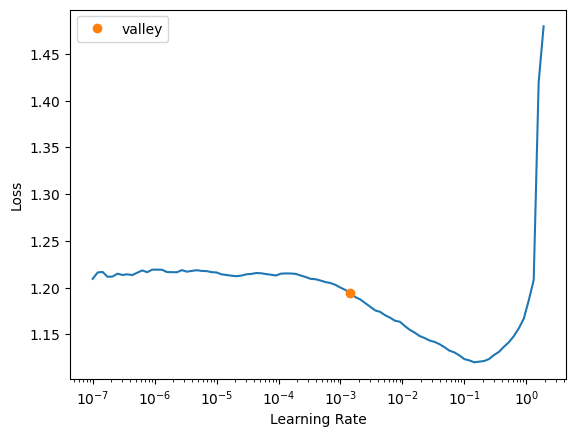

In [10]:
lr = learn.lr_find()
lr

## Train


In [ ]:
learn.fit_one_cycle(25, lr.valley)

Could not gather input dimensions
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'Dataset' object has no attribute 'items'


epoch,train_loss,valid_loss,COCOMetric,time


## Show results

We can now look athe results of the training in the notebook.

In [ ]:
model_type.show_results(model, valid_ds)

## Get predictions

In [ ]:
infer_dl = model_type.infer_dl(valid_ds, batch_size=8)
preds = model_type.predict_from_dl(model=model, infer_dl=infer_dl, keep_images=True)

## Log results to W&B

Now comes the most important bit of this tutorial - actually logging the predictions to W&B. This takes one line specific to icevision and a second line to send the information to W&B.

In [ ]:
# Create wandb_images for each prediction
wandb_images = wandb_img_preds(preds, add_ground_truth=True) 

# Log the wandb_images to wandb
wandb.log({"Predicted images": wandb_images})

After logging and finishing the training, it is good to mark the run as completed. This can take a few seconds, as we wait for the W&B processes to transfer data and finalize logging.

In [ ]:
# optional: mark the run as completed
wandb.join()